<a href="https://colab.research.google.com/github/eduardez/Machine-Learning-ESI/blob/master/Dengue_task_shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

#Autocorrelation
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load the provided data
train_features_raw = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_train.csv?token=ANLXPWLSBAHLW7JMOAVKME276B3UC',
                             index_col=[0,1,2])

train_labels_raw = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_labels_train.csv?token=ANLXPWJ55GZEX4IWHXQA3IS76B3WQ',
                           index_col=[0,1,2])

features_test_raw = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_test.csv?token=ANLXPWOAY3AS6JWDRSIMHI276CDY6',
                           index_col=[0,1,2])

submission = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/submission_format.csv?token=ANLXPWPCMTBVVHBSCUFJB5C76CEHE',
                           index_col=[0,1,2])

In [3]:
train_features = train_features_raw.copy()
train_labels = train_labels_raw.copy()

In [4]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [5]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [6]:
na_ratio = ((sj_train_features.isnull().sum() / len(sj_train_features))*100).sort_values(ascending = False)
print(na_ratio)

ndvi_ne                                  20.405983
ndvi_nw                                   5.235043
ndvi_se                                   2.029915
ndvi_sw                                   2.029915
precipitation_amt_mm                      0.961538
reanalysis_sat_precip_amt_mm              0.961538
station_precip_mm                         0.641026
reanalysis_max_air_temp_k                 0.641026
reanalysis_air_temp_k                     0.641026
reanalysis_avg_temp_k                     0.641026
reanalysis_dew_point_temp_k               0.641026
reanalysis_min_air_temp_k                 0.641026
station_min_temp_c                        0.641026
reanalysis_precip_amt_kg_per_m2           0.641026
reanalysis_relative_humidity_percent      0.641026
reanalysis_specific_humidity_g_per_kg     0.641026
reanalysis_tdtr_k                         0.641026
station_avg_temp_c                        0.641026
station_diur_temp_rng_c                   0.641026
station_max_temp_c             

In [7]:
na_ratio = ((iq_train_features.isnull().sum() / len(iq_train_features))*100).sort_values(ascending = False)
print(na_ratio)

station_diur_temp_rng_c                  7.115385
station_avg_temp_c                       7.115385
station_precip_mm                        3.076923
station_max_temp_c                       2.692308
station_min_temp_c                       1.538462
precipitation_amt_mm                     0.769231
reanalysis_air_temp_k                    0.769231
reanalysis_avg_temp_k                    0.769231
reanalysis_dew_point_temp_k              0.769231
reanalysis_max_air_temp_k                0.769231
reanalysis_min_air_temp_k                0.769231
reanalysis_precip_amt_kg_per_m2          0.769231
reanalysis_relative_humidity_percent     0.769231
reanalysis_sat_precip_amt_mm             0.769231
reanalysis_specific_humidity_g_per_kg    0.769231
reanalysis_tdtr_k                        0.769231
ndvi_sw                                  0.576923
ndvi_se                                  0.576923
ndvi_nw                                  0.576923
ndvi_ne                                  0.576923


In [8]:
sj_train_features.drop('ndvi_ne', axis=1, inplace=True)
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)


# Correlation

In [9]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()


Text(0.5, 1.0, 'San Juan Variable Correlations')

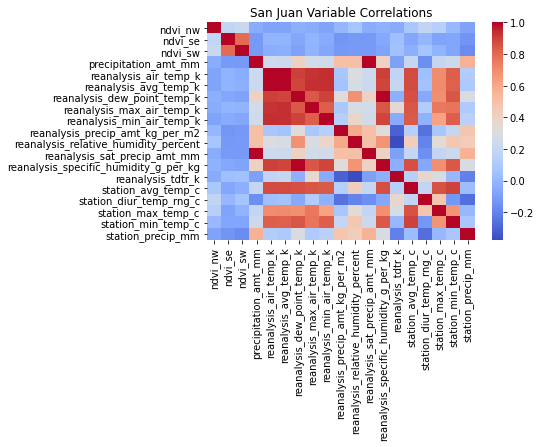

In [10]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations,cmap='coolwarm',xticklabels=True, yticklabels=True)
plt.title('San Juan Variable Correlations')

Text(0.5, 1.0, 'Iquitos Variable Correlations')

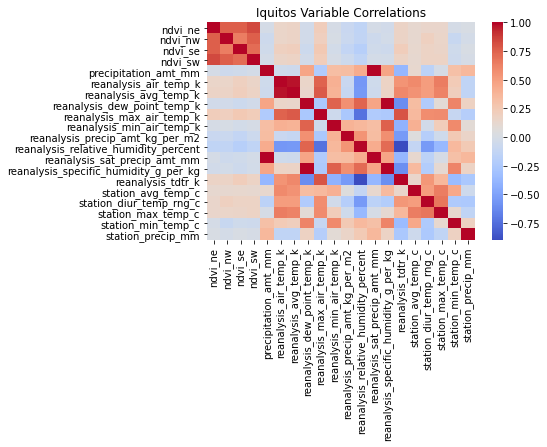

In [11]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations,cmap='coolwarm',xticklabels=True, yticklabels=True)
plt.title('Iquitos Variable Correlations')

In [12]:
def cross_corr(x, y, lag=0):
    return x.corr(y.shift(lag))


def shift_Factor(x, y, R):
    x_corr = [cross_corr(x, y, lag=i) for i in range(R)]

    # R factor is the number of the shifts who should be checked by the function
    Kot = pd.DataFrame(list(x_corr)).reset_index()
    Kot.rename(columns={0: 'Corr', 'index': 'Shift_num'}, inplace=True)

    # We find optimal correlation shift
    Kot['abs'] = Kot['Corr'].abs()
    SF = Kot.loc[Kot['abs'] == Kot['abs'].max(), 'Shift_num']
    p1 = SF.to_frame()
    SF = p1.Shift_num.max()

    return SF

In [13]:
def df_shif(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for h in df.columns:
        if h == target:
            new[h] = df[target]
        else:
            new[h] = df[h].shift(periods=lag)
    return  pd.DataFrame(data=new)

In [14]:
y = sj_train_labels.total_cases #target
R = 52 #week of shift
sj_train_features_shift = pd.DataFrame()

for i in sj_train_features.columns[1:]:
  x = sj_train_features[i]
  SKO = shift_Factor(x,y,R)
  print('Optimal shift for ' + i + ' : ', SKO)
  print(cross_corr(x, y, lag=SKO))
  sj_train_features_shift = sj_train_features_shift.append(df_shif(sj_train_features, i, lag=SKO))

sj_train_features_shift.head(53)

Optimal shift for ndvi_nw :  39
0.14723388999740247
Optimal shift for ndvi_se :  3
-0.1427366515686202
Optimal shift for ndvi_sw :  45
-0.0553554515363297
Optimal shift for precipitation_amt_mm :  44
0.12959494130159901
Optimal shift for reanalysis_air_temp_k :  18
-0.38829841949358784
Optimal shift for reanalysis_avg_temp_k :  18
-0.38455039160917887
Optimal shift for reanalysis_dew_point_temp_k :  18
-0.3521935254914244
Optimal shift for reanalysis_max_air_temp_k :  18
-0.34704652453088936
Optimal shift for reanalysis_min_air_temp_k :  18
-0.3809419305763171
Optimal shift for reanalysis_precip_amt_kg_per_m2 :  45
0.18635114368876396
Optimal shift for reanalysis_relative_humidity_percent :  45
0.28631612982933663
Optimal shift for reanalysis_sat_precip_amt_mm :  44
0.12959494130159901
Optimal shift for reanalysis_specific_humidity_g_per_kg :  18
-0.35200692758252944
Optimal shift for reanalysis_tdtr_k :  51
-0.16605980269851714
Optimal shift for station_avg_temp_c :  42
0.368134232764

week_start_date  ...  station_precip_mm
year weekofyear                  ...                   
1990 18                     NaN  ...                NaN
     19                     NaN  ...                NaN
     20                     NaN  ...                NaN
     21                     NaN  ...                NaN
     22                     NaN  ...                NaN
     23                     NaN  ...                NaN
     24                     NaN  ...                NaN
     25                     NaN  ...                NaN
     26                     NaN  ...                NaN
     27                     NaN  ...                NaN
     28                     NaN  ...                NaN
     29                     NaN  ...                NaN
     30                     NaN  ...                NaN
     31                     NaN  ...                NaN
     32                     NaN  ...                NaN
     33                     NaN  ...                NaN
     34                     NaN  ...                NaN
     35                     NaN  ...                NaN
     36                     NaN  ...                NaN
     37                     NaN  ...                NaN
     38                     NaN  ...                NaN
     39                     NaN  ...                NaN
     40                     NaN  ...                NaN
     41                     NaN  ...                NaN
     42                     NaN  ...                NaN
     43                     NaN  ...                NaN
     44                     NaN  ...                NaN
     45                     NaN  ...                NaN
     46                     NaN  ...                NaN
     47                     NaN  ...                NaN
     48                     NaN  ...                NaN
     49                     NaN  ...                NaN
     50                     NaN  ...                NaN
     51                     NaN  ...                NaN
     52                     NaN  ...                NaN
1991 1                      NaN  ...                NaN
     2                      NaN  ...                NaN
     3                      NaN  ...                NaN
     4                      NaN  ...                NaN
     5               1990-04-30  ...               16.0
     6               1990-05-07  ...                8.6
     7               1990-05-14  ...               41.4
     8               1990-05-21  ...                4.0
     9               1990-05-28  ...                5.8
     10              1990-06-04  ...               39.1
     11              1990-06-11  ...               29.7
     12              1990-06-18  ...               21.1
     13              1990-06-25  ...               21.1
     14              1990-07-02  ...                1.1
     15              1990-07-09  ...               63.7
     16              1990-07-16  ...               12.2
     17              1990-07-23  ...               32.6
     18              1990-07-30  ...               37.6

[53 rows x 20 columns]

In [15]:
iq_train_features_shift = pd.DataFrame()
for i in iq_train_features.columns[1:]:
  x = iq_train_features[i]
  SKO = shift_Factor(x,y,R)
  print('Optimal shift for ' + i + ' : ', SKO)
  print(cross_corr(x, y, lag=SKO))
  iq_train_features_shift = iq_train_features_shift.append(df_shif(iq_train_features, i, lag=SKO))

iq_train_features_shift.head(53)

Optimal shift for ndvi_ne :  2
0.18664445204495544
Optimal shift for ndvi_nw :  1
0.20858107753949423
Optimal shift for ndvi_se :  47
0.25923917827123955
Optimal shift for ndvi_sw :  2
0.2689276650404023
Optimal shift for precipitation_amt_mm :  21
0.23547444547488963
Optimal shift for reanalysis_air_temp_k :  5
0.3342992779488328
Optimal shift for reanalysis_avg_temp_k :  2
0.3288594664617104
Optimal shift for reanalysis_dew_point_temp_k :  45
-0.37144109862990715
Optimal shift for reanalysis_max_air_temp_k :  0
0.3755878377303714
Optimal shift for reanalysis_min_air_temp_k :  39
-0.402035737812586
Optimal shift for reanalysis_precip_amt_kg_per_m2 :  45
-0.3024125379540646
Optimal shift for reanalysis_relative_humidity_percent :  0
-0.34870944996158465
Optimal shift for reanalysis_sat_precip_amt_mm :  21
0.23547444547488963
Optimal shift for reanalysis_specific_humidity_g_per_kg :  44
-0.37657871721555825
Optimal shift for reanalysis_tdtr_k :  47
0.3970558640687485
Optimal shift for s

week_start_date  ...  station_precip_mm
year weekofyear                  ...                   
2000 26                     NaN  ...                NaN
     27                     NaN  ...                NaN
     28              2000-07-01  ...                3.0
     29              2000-07-08  ...               55.6
     30              2000-07-15  ...               38.1
     31              2000-07-22  ...               30.0
     32              2000-07-29  ...                4.0
     33              2000-08-05  ...               11.5
     34              2000-08-12  ...               72.9
     35              2000-08-19  ...               50.1
     36              2000-08-26  ...               89.2
     37              2000-09-02  ...               78.0
     38              2000-09-09  ...               56.9
     39              2000-09-16  ...               18.9
     40              2000-09-23  ...              104.2
     41              2000-09-30  ...               57.9
     42              2000-10-07  ...               63.0
     43              2000-10-14  ...                3.0
     44              2000-10-21  ...               45.2
     45              2000-10-28  ...               57.9
     46              2000-11-04  ...                7.1
     47              2000-11-11  ...               13.5
     48              2000-11-18  ...                0.0
     49              2000-11-25  ...                0.0
     50              2000-12-02  ...               19.0
     51              2000-12-09  ...                0.8
2001 1               2000-12-16  ...               67.2
     2               2000-12-23  ...                0.0
     3               2001-01-01  ...               38.9
     4               2001-01-08  ...               59.9
     5               2001-01-15  ...               52.0
     6               2001-01-22  ...              166.9
     7               2001-01-29  ...              147.8
     8               2001-02-05  ...                3.3
     9               2001-02-12  ...               83.1
     10              2001-02-19  ...               38.1
     11              2001-02-26  ...               21.1
     12              2001-03-05  ...               87.1
     13              2001-03-12  ...               39.9
     14              2001-03-19  ...               70.8
     15              2001-03-26  ...               80.0
     16              2001-04-02  ...               46.2
     17              2001-04-09  ...              120.1
     18              2001-04-16  ...               45.3
     19              2001-04-23  ...               14.9
     20              2001-04-30  ...               51.0
     21              2001-05-07  ...               66.0
     22              2001-05-14  ...                0.0
     23              2001-05-21  ...               64.1
     24              2001-05-28  ...               32.0
     25              2001-06-04  ...               17.0
     26              2001-06-11  ...               37.1
     27              2001-06-18  ...                9.9

[53 rows x 21 columns]

Text(0.5, 1.0, 'Iquitos Variable Correlations')

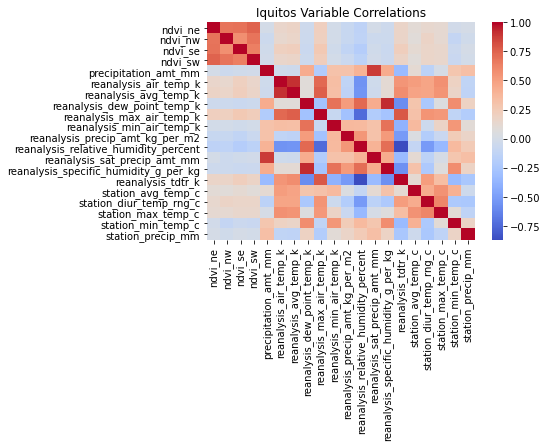

In [16]:
# plot iquitos
iq_correlations_shift = iq_train_features_shift.corr()
iq_corr_heat_shift = sns.heatmap(iq_correlations_shift,cmap='coolwarm',xticklabels=True, yticklabels=True)
plt.title('Iquitos Variable Correlations')


Text(0.5, 1.0, 'San Juan Variable Correlations')

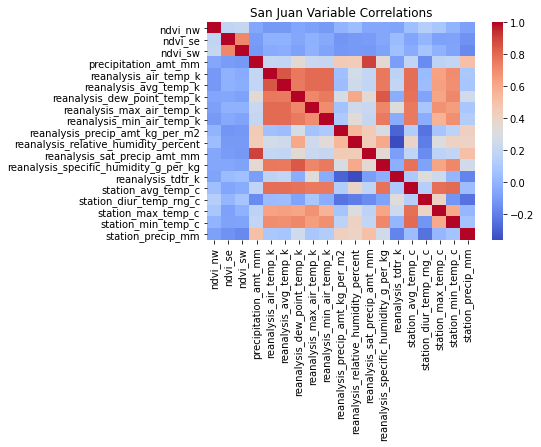

In [17]:
# plot San Juan
sj_correlations_shift = sj_train_features_shift.corr()
sj_corr_heat_shift = sns.heatmap(sj_correlations_shift,cmap='coolwarm',xticklabels=True, yticklabels=True)
plt.title('San Juan Variable Correlations')

# Mostrar features

In [18]:
X = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_train.csv?token=ANLXPWLSBAHLW7JMOAVKME276B3UC')

y = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_labels_train.csv?token=ANLXPWJ55GZEX4IWHXQA3IS76B3WQ')

In [19]:
def yearly_pattern(city, year, ylim = (0,200)):
    df = y[y['city'] == city][y['year'] == year]
    df.plot.bar('weekofyear', 'total_cases', legend=False, ylim = ylim,figsize=(12,5))

# San Juan

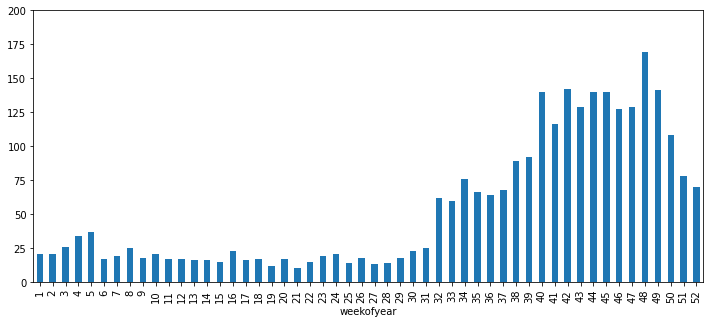

In [20]:
yearly_pattern('sj', 1991, (0,200))


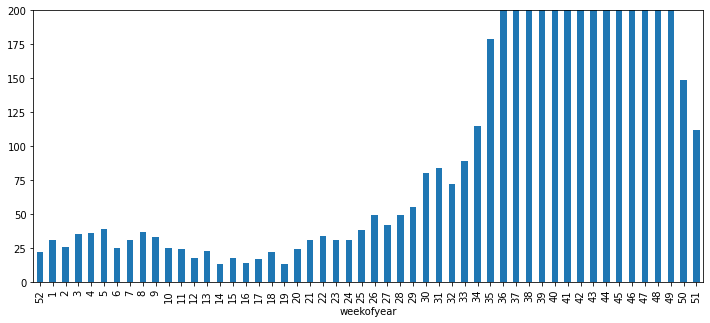

In [21]:
yearly_pattern('sj', 1994,(0,200))

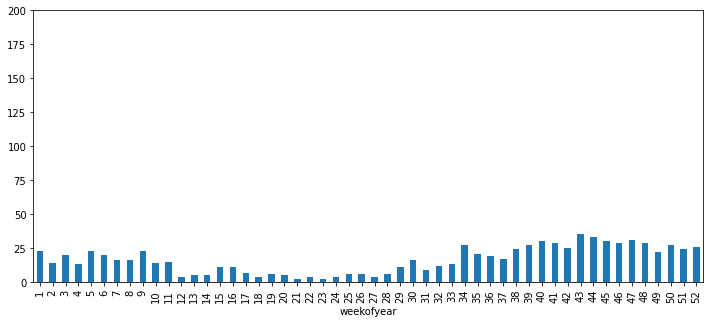

In [22]:
yearly_pattern('sj', 1996, (0,200))


# Conclusion for San Juan


1.   The number of cases per week peak seems to peak in the final quarter of the year. (In most cases)
2.   This indicates the possibility of some correlation between the climate and Dengue spread





# Iquitos

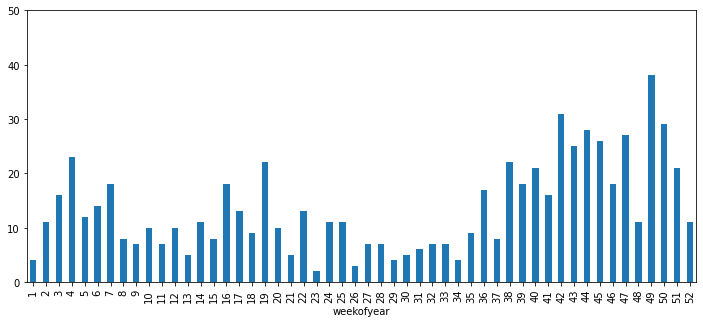

In [23]:
yearly_pattern('iq', 2002, (0,50))

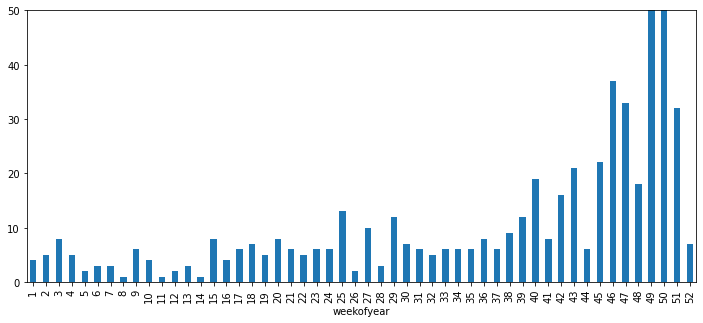

In [24]:
yearly_pattern('iq', 2004, (0,50))

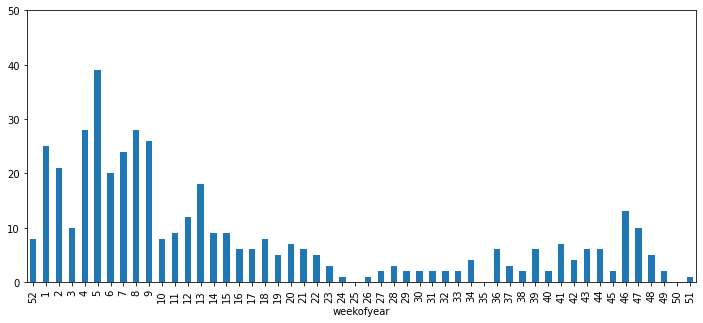

In [25]:
yearly_pattern('iq', 2006, (0,50))

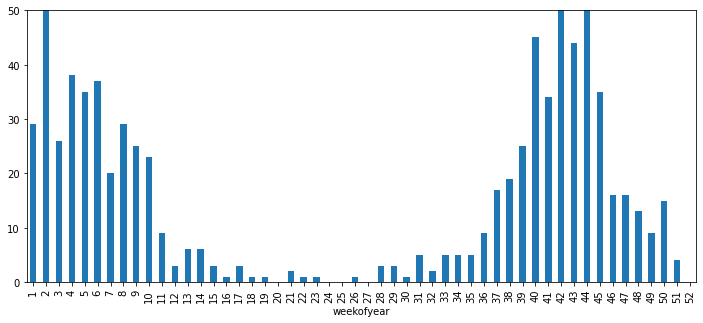

In [26]:
yearly_pattern('iq', 2008, (0,50))

# Conclusion for Iquitos 



*   For the city of Iquitos, there is no strong annual pattern in the number of dengue cases per week
*   There still is some possibility of a correlation between the city's climate and the disease, if we find that even the climate doesn't show a strict annual pattern



#Features

### Pre-processing



*The timing of the seasonality of our predictions has a mismatch with the actual results. One potential reason for this is that our features don't look far enough into the past--that is to say, we are asking to predict cases at the same time as we are measuring percipitation. Because dengue is misquito born, and the misquito lifecycle depends on water, we need to take both the life of a misquito and the time between infection and symptoms into account when modeling dengue. This is a critical avenue to explore when improving this model.*

For this reason, we use shift

In [27]:
iq_train_features_shift.fillna(method='ffill', inplace=True)
sj_train_features_shift.fillna(method='ffill', inplace=True)

sj_train_features_shift['total_cases'] = sj_train_labels.total_cases
iq_train_features_shift['total_cases'] = iq_train_labels.total_cases


In [28]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])

    #we remove those features we high correlation between them
    df.drop('week_start_date', axis=1, inplace=True)
    df.drop("reanalysis_sat_precip_amt_mm", axis = 1, inplace = True)

    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj_train = df.loc['sj']
    iq_train = df.loc['iq']

    # add new feautures with shifts

    sj_train, iq_train = shift(sj_train, iq_train)

    # select features we want
    sj_features = ['reanalysis_specific_humidity_g_per_kg',
               'station_min_temp_c',
               'station_avg_temp_c',
               'reanalysis_specific_humidity_g_per_kg',
               'station_max_temp_c',
               'reanalysis_dew_point_temp_k']

    iq_features = ['reanalysis_specific_humidity_g_per_kg',
                  'reanalysis_dew_point_temp_k',
                  'reanalysis_min_air_temp_k',
                  'station_min_temp_c','reanalysis_tdtr_k','ndvi_sw']
    if labels_path:
      sj_features.append('total_cases')
      iq_features.append('total_cases')

    sj_train = sj_train[sj_features]
    iq_train = iq_train[iq_features] 

    return sj_train, iq_train

### Quick Check for Autocorrelation

[Autoregression Models for Time Series Forecasting With Python](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)

*The other important error is that our predictions are relatively consistent--we miss the spikes that are large outbreaks. One reason is that we don't take into account the contagiousness of dengue. A possible way to account for this is to build a model that progressively predicts a new value while taking into account the previous prediction. By training on the dengue outbreaks and then using the predicted number of patients in the week before, we can start to model this time dependence that the current model misses.*

In [29]:
    sj_train_labels = train_labels.loc['sj']
    iq_train_labels = train_labels.loc['iq']

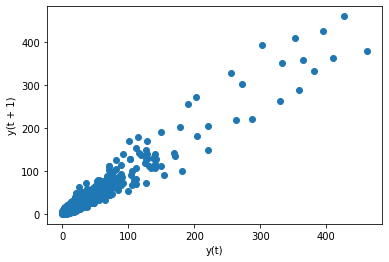

In [30]:

lag_plot(sj_train_labels, lag=1)
plt.show()


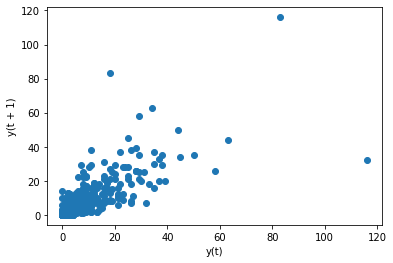

In [31]:
lag_plot(iq_train_labels, lag=1)
plt.show()

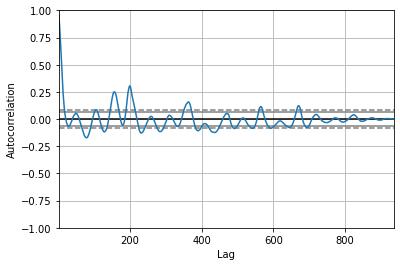

In [32]:
autocorrelation_plot(sj_train_labels)
plt.show()

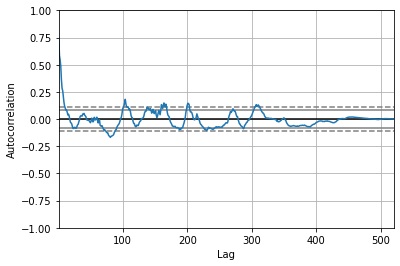

In [33]:
autocorrelation_plot(iq_train_labels)
plt.show()

In [34]:
train_labels_date = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_labels_train.csv?token=ANLXPWJ55GZEX4IWHXQA3IS76B3WQ')



train_labels_date['formatted_date'] = train_labels_date.year * 1000 + train_labels_date.weekofyear * 10 + 0

train_labels_date['date'] = pd.to_datetime(train_labels_date['formatted_date'], format='%Y%W%w')
train_labels_date.drop('year', axis=1, inplace=True)
train_labels_date.drop('weekofyear', axis=1, inplace=True)
train_labels_date.drop('formatted_date', axis=1, inplace=True)
train_labels_date.set_index(['city','date'], inplace=True)

print (train_labels_date)

sj_train_labels_date = train_labels_date.loc['sj']
iq_train_labels_date = train_labels_date.loc['iq']

                 total_cases
city date                   
sj   1990-05-06            4
     1990-05-13            5
     1990-05-20            4
     1990-05-27            3
     1990-06-03            6
...                      ...
iq   2010-05-30            5
     2010-06-06            8
     2010-06-13            1
     2010-06-20            1
     2010-06-27            4

[1456 rows x 1 columns]


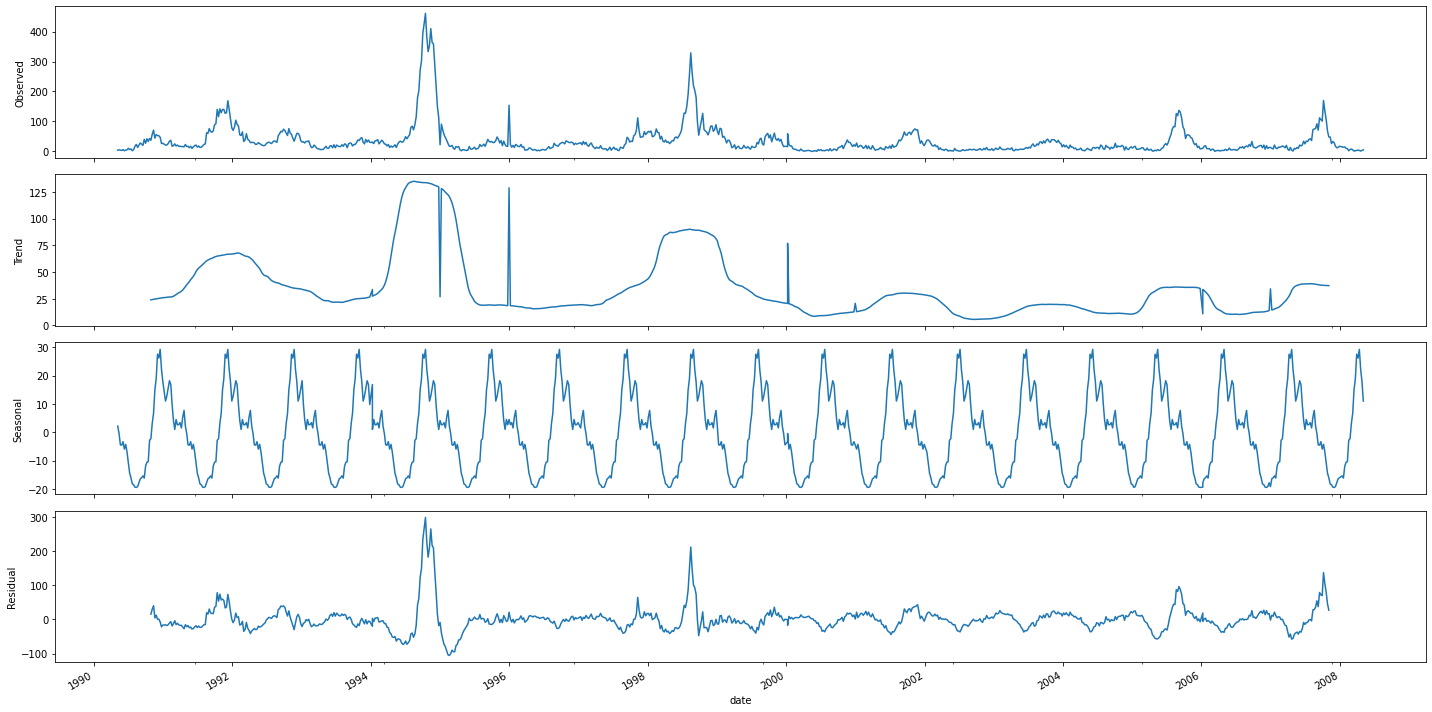

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

result = seasonal_decompose(sj_train_labels_date, model= 'additive', freq = 50)
pyplot.rcParams["figure.figsize"] = [20,10]
result.plot()
pyplot.show()

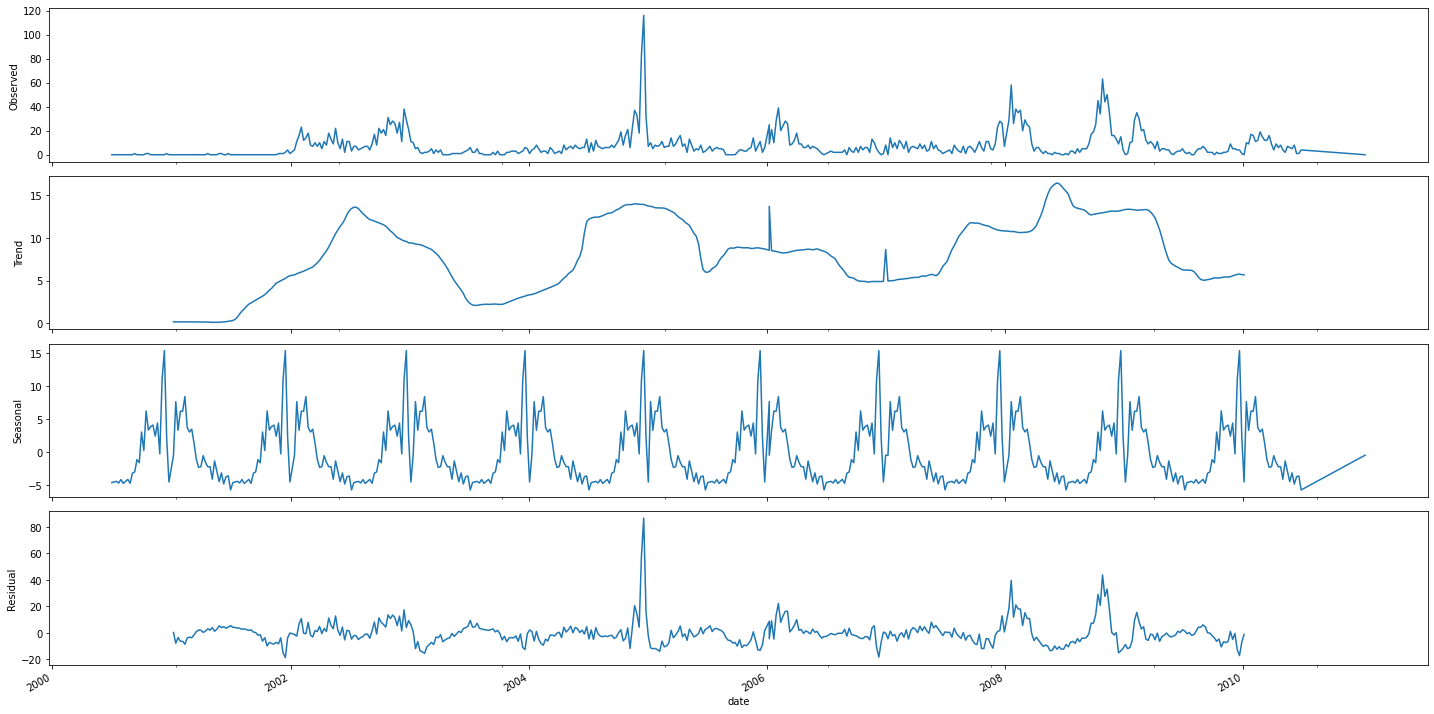

In [36]:

result = seasonal_decompose(iq_train_labels_date, model= 'additive', freq = 52)
pyplot.rcParams["figure.figsize"] = [20,10]
result.plot()
pyplot.show()

### Study of correlations

In [37]:
#sj_train_features, iq_train_features= preprocess_data('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_train.csv?token=ANLXPWLSBAHLW7JMOAVKME276B3UC', labels_path="https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_labels_train.csv?token=ANLXPWJ55GZEX4IWHXQA3IS76B3WQ")
sj_train_features= sj_train_features_shift
iq_train_features=sj_train_features_shift                               

In [38]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

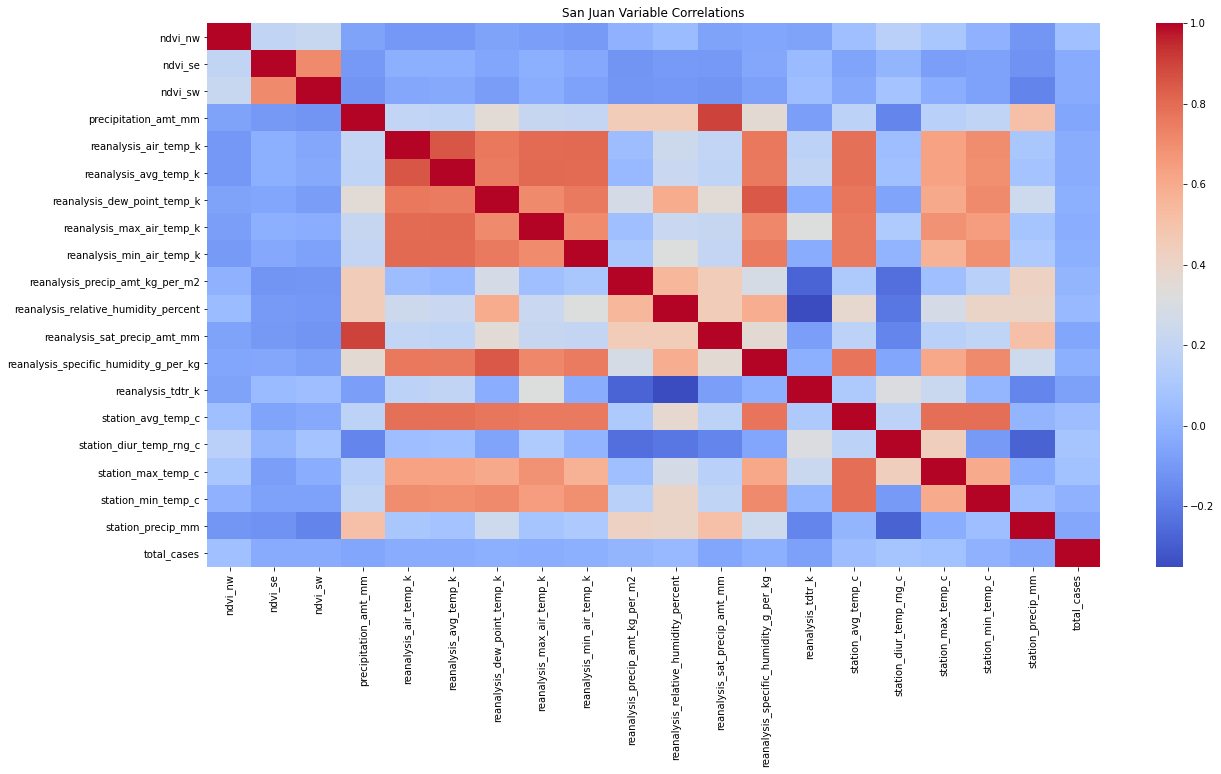

In [39]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations,cmap='coolwarm',xticklabels=True, yticklabels=True)
plt.title('San Juan Variable Correlations')

In [40]:
sol = (sj_correlations.where(np.triu(np.ones(sj_correlations.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
for index, value in sol.items():
  if value>0.90:
    print(index, value)

('precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm') 0.900186605553176


In [41]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False))

station_diur_temp_rng_c                  0.082399
station_max_temp_c                       0.067108
ndvi_nw                                  0.064712
station_avg_temp_c                       0.049988
reanalysis_relative_humidity_percent     0.029885
reanalysis_precip_amt_kg_per_m2          0.009169
station_min_temp_c                       0.000212
reanalysis_dew_point_temp_k             -0.009668
reanalysis_min_air_temp_k               -0.009699
reanalysis_specific_humidity_g_per_kg   -0.011858
reanalysis_max_air_temp_k               -0.023261
reanalysis_avg_temp_k                   -0.026322
reanalysis_air_temp_k                   -0.026796
ndvi_se                                 -0.029657
ndvi_sw                                 -0.030029
station_precip_mm                       -0.048117
reanalysis_sat_precip_amt_mm            -0.050520
precipitation_amt_mm                    -0.050520
reanalysis_tdtr_k                       -0.076100
Name: total_cases, dtype: float64

Text(0.5, 1.0, 'Iquitos Variable Correlations')

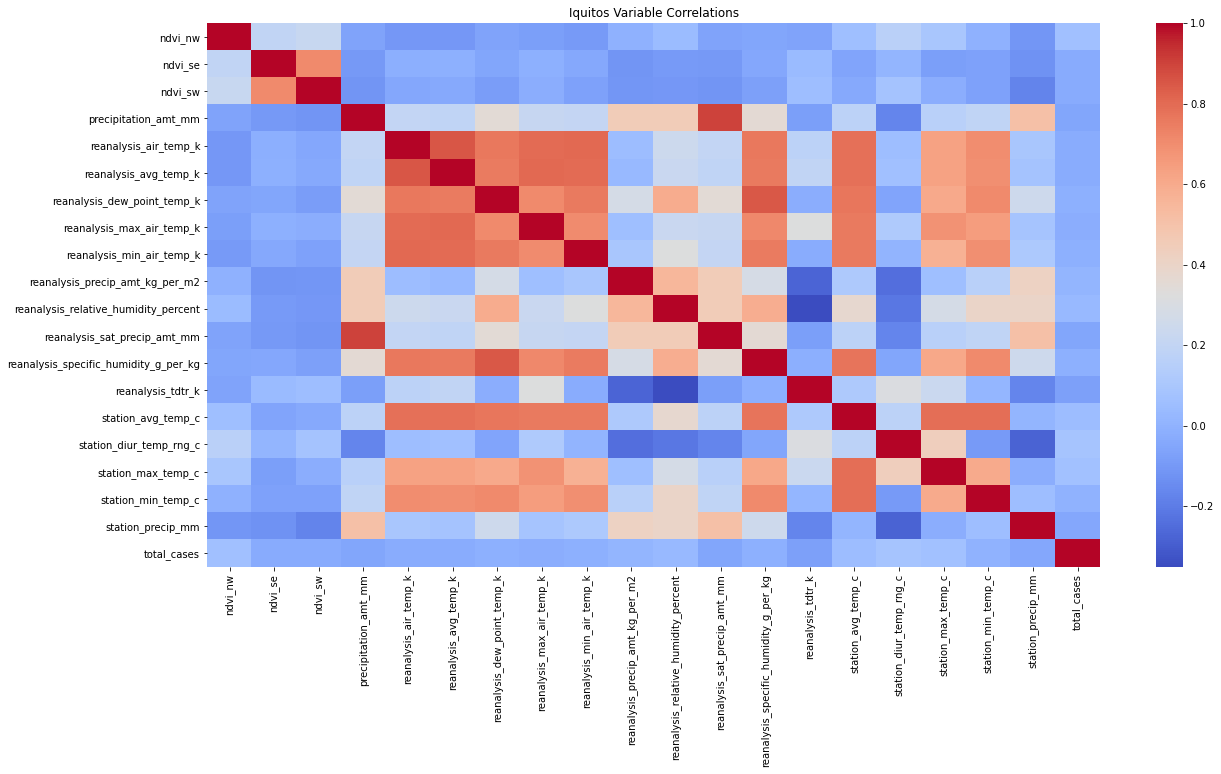

In [42]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations,cmap='coolwarm',xticklabels=True, yticklabels=True)
plt.title('Iquitos Variable Correlations')

In [43]:
sol = (iq_correlations.where(np.triu(np.ones(iq_correlations.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
for index, value in sol.items():
  if value>0.90:
    print(index, value)

('precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm') 0.900186605553176


In [44]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False))


station_diur_temp_rng_c                  0.082399
station_max_temp_c                       0.067108
ndvi_nw                                  0.064712
station_avg_temp_c                       0.049988
reanalysis_relative_humidity_percent     0.029885
reanalysis_precip_amt_kg_per_m2          0.009169
station_min_temp_c                       0.000212
reanalysis_dew_point_temp_k             -0.009668
reanalysis_min_air_temp_k               -0.009699
reanalysis_specific_humidity_g_per_kg   -0.011858
reanalysis_max_air_temp_k               -0.023261
reanalysis_avg_temp_k                   -0.026322
reanalysis_air_temp_k                   -0.026796
ndvi_se                                 -0.029657
ndvi_sw                                 -0.030029
station_precip_mm                       -0.048117
reanalysis_sat_precip_amt_mm            -0.050520
precipitation_amt_mm                    -0.050520
reanalysis_tdtr_k                       -0.076100
Name: total_cases, dtype: float64

### Negative binomial regression

In [45]:
sj_train, iq_train = preprocess_data('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_train.csv?token=ANLXPWLSBAHLW7JMOAVKME276B3UC', labels_path="https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_labels_train.csv?token=ANLXPWJ55GZEX4IWHXQA3IS76B3WQ")

NameError: ignored

In [ ]:
sj_train_neg_binomial = sj_train.copy()
iq_train_neg_binomial = iq_train.copy()


In [ ]:
sj_train_subtrain = sj_train_neg_binomial.head(800)
sj_train_subtest = sj_train_neg_binomial.tail(sj_train_neg_binomial.shape[0] - 800)

iq_train_subtrain = iq_train_neg_binomial.head(400)
iq_train_subtest = iq_train_neg_binomial.tail(iq_train_neg_binomial.shape[0] - 400)

In [ ]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

def get_best_model(train, test, ciudad):
    # Step 1: specify the form of the model
    if ciudad == 'sj':
      model_formula = "total_cases ~ 1 + " \
                      "reanalysis_specific_humidity_g_per_kg + " \
                      "station_min_temp_c + " \
                      "station_avg_temp_c + " \
                      "station_max_temp_c + " \
                      "reanalysis_dew_point_temp_k + " \
                      "reanalysis_specific_humidity_g_per_kg"
    elif ciudad == 'iq':
      model_formula = "total_cases ~ 1 + " \
                "reanalysis_specific_humidity_g_per_kg + " \
                "reanalysis_dew_point_temp_k + " \
                "reanalysis_min_air_temp_k + " \
                "reanalysis_tdtr_k + " \
                "ndvi_sw + " \
                "station_min_temp_c"

    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    

In [ ]:
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest,'sj')
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest,'iq')

In [ ]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train_neg_binomial['fitted'] = sj_best_model.fittedvalues
sj_train_neg_binomial.fitted.plot(ax=axes[0], label="Predictions")
sj_train_neg_binomial.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train_neg_binomial['fitted'] = iq_best_model.fittedvalues
iq_train_neg_binomial.fitted.plot(ax=axes[1], label="Predictions")
iq_train_neg_binomial.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

### KNeighbors Regressor

In [ ]:
sj_train_knn = sj_train.copy()
sj_train_knn.reset_index(drop = True, inplace = True)

iq_train_knn = iq_train.copy()
iq_train_knn.reset_index(drop = True, inplace = True)

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 20, shuffle = False) #
#  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html 

def knn(train_knn):
  for i, weights in enumerate(['uniform', 'distance']):
    total_scores = []
    for n_neighbors in range(1,80):
        fold_accuracy = []
        knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights, metric='euclidean')
        # verificar cada uno de los modelos con validación cruzada.
        for train_fold, test_fold in cv.split(train_knn):
            # División train test aleatoria
            f_train = train_knn.loc[train_fold]
            f_test = train_knn.loc[test_fold]
            # entrenamiento y ejecución del modelo
            knn.fit( X = f_train.drop(['total_cases'], axis=1), 
                                y = f_train['total_cases'])
            y_pred = knn.predict(X = f_test.drop(['total_cases'], axis = 1))
            # evaluación del modelo
            mae = mean_absolute_error(f_test['total_cases'], y_pred)
            fold_accuracy.append(mae)
        total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
    
    plt.plot(range(1,len(total_scores)+1), total_scores, 
              marker='o', label=weights)
    print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
    plt.ylabel('MAE')

  plt.legend()
  plt.show() 





In [ ]:
knn(sj_train_knn )

In [ ]:
knn(iq_train_knn)

In [ ]:
# constructor
n_neighbors = 63
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights, metric='euclidean') 
# fit and predict

knn.fit( X = sj_train_knn.drop(['total_cases'], axis=1), y = sj_train_knn['total_cases'])
y_pred_sj = knn.predict(X = sj_train_knn.drop(['total_cases'], axis = 1))

mae = mean_absolute_error(sj_train_knn['total_cases'], y_pred_sj)
print ('MAE', mae)


In [ ]:
# constructor
n_neighbors = 40
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = iq_train_knn.drop(['total_cases'], axis=1), y = iq_train_knn['total_cases'])
y_pred_iq = knn.predict(X = iq_train_knn.drop(['total_cases'], axis = 1))

mae = mean_absolute_error(iq_train_knn['total_cases'], y_pred_iq)
print ('MAE', mae)

In [ ]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj

sj_train_knn.total_cases.plot(ax=axes[0], label="Actual")
axes[0].plot(y_pred_sj, label="Knn")

# plot iq
iq_train_knn.total_cases.plot(ax=axes[1], label="Actual")
axes[1].plot(y_pred_iq, label="Knn")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [ ]:
sj_test, iq_test = preprocess_data('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_test.csv?token=ANLXPWOAY3AS6JWDRSIMHI276CDY6')

#ensemble (mean)

"""
sj_predictions = ((knn.predict(sj_test) + sj_best_model.predict(sj_test))/2).astype(int)
iq_predictions = ((knn.predict(iq_test) + iq_best_model.predict(iq_test))/2).astype(int)
"""

#full knn regressor
"""
sj_predictions = knn.predict(sj_test).astype(int)
iq_predictions = knn.predict(iq_test).astype(int)
"""
#full negative regressor

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)



submission.total_cases = np.concatenate([sj_predictions, iq_predictions])

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

submission.to_csv("benchmark.csv")